This script solves the 2D heat equation analytically for several different initial conditions. From this data, it learns the explicit Euler update for the heat equation, $u^{n+1} = \left( I + \Delta t \mathcal{L} \right) u^n$, where $\mathcal{L}$ is a parameterized spatial operator.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import scipy.special
import itertools
import random
import toolz

#classes for parameterized spatial operators
import morp

In [2]:
L=2*np.pi               #domain, (x,y) \in [0,2\pi]x[0,2\pi]
n=64                    #grid points in x and y
dt=5e-4                 #timestep size
nt = 100                #number of timesteps
t = np.arange(nt)*dt
samps = 100             #number of initial conditions

#architecture for neural networks, g and h
depth=8
width=8


M=8              #maximum number of composed updates in regression
bs=100           #batch size
epochs = 4

#wavevectors
k = np.transpose(np.meshgrid(np.fft.fftfreq(n,d=L/n)*2*np.pi,
                             np.fft.rfftfreq(n,d=L/n)*2*np.pi,
                             indexing='ij'),(1,2,0))

In [3]:
#generates analytical solutions
def gen():
    uh = n*np.exp(1.0j*np.random.uniform(0,2*np.pi,(n,n//2+1)))  \
                   *scipy.special.erfc( (np.sqrt(np.sum(k**2,-1)) - 10)*.1)
    return np.fft.irfft2(np.exp(-np.sum(k**2,-1)*np.reshape(t,(nt,1,1)))*uh)
utrue = np.stack([gen() for _ in range(samps)],0)

In [4]:
#creates parameterized operator. Assumes conservation, symmetry, isotropy
L = morp.L2d(depth,width,k,cons=True,sym=True,iso=True)

#explicit euler update operator
upd = lambda u: u+L(u)

In [5]:
#performs regression
def maketrain(m,lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr) 
    updm = toolz.compose(*[upd for _ in range(m)])
    @tf.function
    def train(u0,um):
        with tf.GradientTape() as tape:
            tape.watch(u0)
            umpred = updm(u0)
            loss = tf.reduce_mean(tf.keras.losses.mse(um, umpred))
            gradients = tape.gradient(loss, L.vlist)
        opt.apply_gradients(zip(gradients, L.vlist))
        return loss
    return train

lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
for m in range(1,M):
    train = maketrain(m,1e-4)   
    for epoch in range(epochs):
        inds = list(itertools.product(range(samps),range(nt-m)))
        random.shuffle(inds)
        inds = np.array(inds)
        for i in range(len(inds)//bs):
            ind = inds[bs*i:bs*(i+1)]
            u0 = utrue[ind[:,0],ind[:,1]]
            um = utrue[ind[:,0],ind[:,1]+m]
            er = train(u0,um).numpy()

W1006 23:08:53.956599 140736009790336 functional.py:587] Model was constructed with shape (None, 1) for input Tensor("input_2:0", shape=(None, 1), dtype=float64), but it was called on an input with incompatible shape (64, 33, 1, 1).
W1006 23:08:54.092044 140736009790336 functional.py:587] Model was constructed with shape (None, 1) for input Tensor("input_1:0", shape=(None, 1), dtype=float64), but it was called on an input with incompatible shape (100, 64, 64, 1, 1).


In [6]:
#generates analytical solution with new initial condition
utest = gen()

#uses regressed operator to evolve new initial condition
upred = toolz.compose(*[upd for _ in range(nt)])(
                    tf.constant(np.expand_dims(utest[0],0)))

W1007 00:08:15.898519 140736009790336 functional.py:587] Model was constructed with shape (None, 1) for input Tensor("input_1:0", shape=(None, 1), dtype=float64), but it was called on an input with incompatible shape (1, 64, 64, 1, 1).


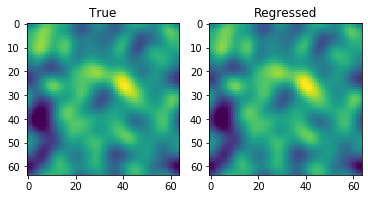

<Figure size 432x288 with 0 Axes>

In [7]:
#plots true solution and solution with regressed operator at final time step
fig,ax = plt.subplots(1,2)
ax[0].imshow(utest[-1],vmin=-.4,vmax=.4)
plt.figure()
ax[1].imshow(upred[0],vmin=-.4,vmax=.4)
ax[0].set_title('True')
ax[1].set_title('Regressed');